In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import json
import os
import rpy2
import anndata
from datetime import date
from scipy.stats import binom_test
from datetime import datetime

# YYYY-MM-DD
today = date.today()
today = today.strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings('ignore')

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in peaks matrix and tidy it

In [2]:
%%time

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
    
print(f'{current_time}:...reading peak file...takes 5 mins...')
peaks=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/Foetal_celltype-by-Peak.csv')
    
peaks.columns = peaks.columns.str.replace('Unnamed: 0', 'fine_grain')
peaks=peaks.set_index(peaks['fine_grain'])
peaks=peaks.drop(columns=['fine_grain'])

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'{current_time}:...done.')

06:37:53:...reading peak file...takes 5 mins...
06:43:06:...done.
CPU times: user 4min 55s, sys: 7.08 s, total: 5min 2s
Wall time: 5min 13s


In [3]:
%%time
all_peaks=pd.DataFrame(peaks.columns, columns=['peak'])
all_peaks['chrom']=all_peaks['peak'].str.split(':',expand=True)[0]
all_peaks['peak_window']=all_peaks['peak'].str.split(':',expand=True)[1]
all_peaks['start']=all_peaks['peak_window'].str.split('_',expand=True)[0].astype(int)
all_peaks['end']=all_peaks['peak_window'].str.split('_',expand=True)[1].astype(int)
all_peaks=all_peaks.set_index(['peak'])
all_peaks.head(4)

CPU times: user 5.21 s, sys: 116 ms, total: 5.32 s
Wall time: 5.32 s


,chrom,peak_window,start,end
peak,,,,
chr1:794775_795275,chr1,794775_795275,794775,795275
chr1:817100_817600,chr1,817100_817600,817100,817600
chr1:817796_818296,chr1,817796_818296,817796,818296
chr1:818511_819011,chr1,818511_819011,818511,819011


# Set parameters for subsequent analysis

### Set Cell types

In [4]:
# get list of celltypes for subsequent analyses
cell_types=peaks.index.unique().tolist()
#cell_types=cell_types[25:27] # reduced while developing
print(cell_types)

['VentricularConductionSystemDistal', 'DendriticCells', 'GreatVesselAdventitialFibroblasts', 'GlialCells', 'AtrialCardiomyocytesRight', 'ParasympatheticNeurons', 'CoronaryEndothelialCellsVenous', 'VentricularCardiomyocytesCycling', 'NeuronProgenitors', 'MastCells', 'ProBCells', 'LymphaticEndothelialCells', 'AtrialCardiomyocytesCycling', 'NaturalKillerCells', 'AtrioventricularNodeCardiomyocytes', 'ValveInterstitialCells', 'VentricularConductionSystemProximal', 'ValveEndothelialCells', 'MacrophagesLYVE1pos', 'InnateLymphoidCells', 'GreatVesselSmoothMuscleCells', 'EndocardialCells', 'Monocytes', 'CoronaryVesselAdventitialFibroblasts', 'MesothelialEpicardialCells', 'MyocardialInterstitialFibroblasts', 'CoronaryEndothelialCellsArterial', 'SympatheticNeurons', 'Cardiofibromyocytes', 'ChromaffinCells', 'SinoatrialNodeCardiomyocytes', 'Myofibroblasts', 'BCells', 'FibroblasticEpicardialCells', 'VentricularCardiomyocytesPRRX1pos', 'VentricularCardiomyocytesTrabeculated', 'CoronaryEndothelialCell

### Set n_permutations

In [5]:
# Set number of permutations
n_permutations=1000 # reduced while developing
print(n_permutations)

1000


### Set threshold for binarisation

In [6]:
# Set threshold for binarisation
threshold=0.1
threshold_for_filename=str(threshold).replace('.','p')
print(threshold_for_filename)

0p1


# Make some SNP table metadata

In [8]:
%%time
# make a table of metadata about the SNP files
md_efo_ids=[]
md_efo_terms=[]
md_n_SNPs=[]
pointlessly_small_n_SNPs=[]

snps_path='/nfs/team205/heart/EBI_GWAS/index_snps/'

pointlessly_small_threshold=20

files=os.listdir(snps_path)

efo_ids=[]

for file in range(len(files)):
    efo_ids.append(str(files[file].split("_")[0])+'_'+str(files[file].split("_")[1]))

for efo_id in efo_ids:
    file = [f for f in files if f"{efo_id}" in f]
    file = str(file[0])
    snps_df=pd.read_csv(f'{snps_path}{file}')
    snps_df=snps_df.set_index('variant_id')
    snps_df=snps_df.dropna(axis=0) # remove any rows containign NaNs
    if len(snps_df)<pointlessly_small_threshold:
        pointlessly_small_n_SNPs.append(efo_id)
    else:
        snps_df["chrom"] = snps_df["chromosome_name"].apply(lambda x: 'chr'+str(x)).str.split('.',expand=True)[0] # creates a new 'chrom' column and should work even for X or M chromosomes
        md_efo_ids.append(snps_df['efo_id'][0])
        md_efo_terms.append(snps_df['efo_term'][0])
        md_n_SNPs.append(len(snps_df))

md_dict={
    'efo_id':md_efo_ids,
    'efo_term':md_efo_terms,
    'n_SNPs':md_n_SNPs
}

# re-define efo_id list removing the really short ones.
efo_ids_not_too_small= [efo_id for efo_id in efo_ids if efo_id not in pointlessly_small_n_SNPs]

efo_ids=efo_ids_not_too_small

# Reduce while developing
#efo_ids=efo_ids[25:27] # reduced while developing

n_traits=str(len(efo_ids))

print(n_traits+' traits found. Removed '+str(len(pointlessly_small_n_SNPs))+' traits with fewer than 20 SNPs')

SNP_md=pd.DataFrame(md_dict)
SNP_md=SNP_md.set_index('efo_id')
SNP_md.sort_values('n_SNPs',ascending=False)

89 traits found. Removed 111 traits with fewer than 20 SNPs
CPU times: user 778 ms, sys: 28.5 ms, total: 806 ms
Wall time: 1.44 s


,efo_term,n_SNPs
efo_id,,
MONDO_0005090,schizophrenia,3348
EFO_0001645,coronary artery disease,1907
EFO_0005763,pulse pressure measurement,1706
EFO_0004761,uric acid measurement,633
EFO_0004682,QT interval,592
...,...,...
EFO_1001161,rheumatic heart disease,21
EFO_0005243,myeloperoxidase measurement,21
EFO_0005037,aortic root size,21


<AxesSubplot:>

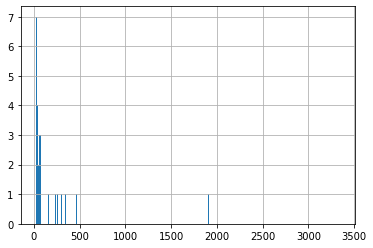

In [16]:
SNP_md['n_SNPs'].hist(bins=1000)

# Evaluate whether SNPs are found in peaks using the all_peaks file

In [18]:
%%time
# Add on a column for each trait, indicating whether a SNP from that trait falls within a peak. This file varies with the which traits are assessed
files=os.listdir(snps_path)

if os.path.isfile(f'/nfs/team205/heart/EBI_GWAS/SNP_mapped_to_peaks/all_peaks_with_SNPs_for_{n_traits}_traits_incremental.csv')==False:
    print(f'...a SNPs in peaks file for this set of traits is not found, making one now...')
    for efo_id in efo_ids:

            file = [f for f in files if f"{efo_id}" in f]
            file = str(file[0])

            snps_df=pd.read_csv(f'{snps_path}{file}')
            snps_df=snps_df.set_index('variant_id')

            snps_df["chrom"] = snps_df["chromosome_name"].apply(lambda x: 'chr'+str(x)).str.split('.',expand=True)[0] # creates a new 'chrom' column and should work even for X or M chrosomes

            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(f'{current_time}_{efo_id}:...evaluating for SNPs in peaks...')

            all_peaks[efo_id]=0
            for snp in range(len(snps_df["chrom"])): # This loop incrementally adds 1 if there is a SNP within a peak (open or closed)
                all_peaks[efo_id][
                    (all_peaks['chrom']==snps_df["chrom"][snp])
                    &
                    (all_peaks['start'] <= snps_df['chromosome_position'][snp])
                    &
                    (all_peaks['end'] >= snps_df['chromosome_position'][snp])
                ]+=1
    all_peaks.to_csv(f'/nfs/team205/heart/EBI_GWAS/SNP_mapped_to_peaks/all_peaks_with_SNPs_for_{n_traits}_traits_incremental.csv')
else:
    all_peaks=pd.read_csv(f'/nfs/team205/heart/EBI_GWAS/SNP_mapped_to_peaks/all_peaks_with_SNPs_for_{n_traits}_traits_incremental.csv',index_col='peak')
    print(f'...SNPs in peaks file already exists, reading it in...')

all_peaks

...a SNPs in peaks file for this set of traits is not found, making one now...
06:46:46_EFO_0000537:...evaluating for SNPs in peaks...
06:47:07_EFO_0000275:...evaluating for SNPs in peaks...
06:47:30_MONDO_0005178:...evaluating for SNPs in peaks...
06:47:36_EFO_0005763:...evaluating for SNPs in peaks...
06:49:03_EFO_0009184:...evaluating for SNPs in peaks...
06:49:05_EFO_0004831:...evaluating for SNPs in peaks...
06:49:06_EFO_0006919:...evaluating for SNPs in peaks...
06:49:09_EFO_0005527:...evaluating for SNPs in peaks...
06:49:10_EFO_0004282:...evaluating for SNPs in peaks...
06:49:12_EFO_0005524:...evaluating for SNPs in peaks...
06:49:17_EFO_0008205:...evaluating for SNPs in peaks...
06:49:20_EFO_0003870:...evaluating for SNPs in peaks...
06:49:26_EFO_0005055:...evaluating for SNPs in peaks...
06:49:42_EFO_0009094:...evaluating for SNPs in peaks...
06:49:44_EFO_0008373:...evaluating for SNPs in peaks...
06:49:45_MONDO_0005090:...evaluating for SNPs in peaks...
06:52:36_EFO_0010071:

,chrom,peak_window,start,end,EFO_0000537,EFO_0000275,MONDO_0005178,EFO_0005763,EFO_0009184,EFO_0004831,...,EFO_0004507,EFO_0000717,EFO_0004326,EFO_0005094,EFO_0006522,EFO_0021787,EFO_0004578,EFO_0004278,EFO_0004269,EFO_0009185
peak,,,,,,,,,,,,,,,,,,,,,
chr1:794775_795275,chr1,794775_795275,794775,795275,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:817100_817600,chr1,817100_817600,817100,817600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:817796_818296,chr1,817796_818296,817796,818296,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:818511_819011,chr1,818511_819011,818511,819011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:820996_821496,chr1,820996_821496,820996,821496,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155768443_155768943,chrX,155768443_155768943,155768443,155768943,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrX:155820075_155820575,chrX,155820075_155820575,155820075,155820575,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrX:155880511_155881011,chrX,155880511_155881011,155880511,155881011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Make a table of peaks x cell for each cell type, binarise using a threshold, then make 1000 permutations, then overwrite the file

In [19]:
%%time

# makes cell x peak matrix, including 1000 permutations
# NB the SNPs in peaks file needs is specific to the defined set of peaks, which will vary accoring to threshold for binarisation, so this all peaks file needs to be saved according to threshold used

permutations=range(n_permutations)

bin_mat_path='/nfs/team205/heart/EBI_GWAS/binarised_permutation_matrices/'

for cell_type in cell_types:
    if os.path.isfile(f'{bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix.csv') == False:

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        
        print(f'{current_time}...generating binarised matrix for {cell_type}...')

        cell_df=pd.DataFrame(peaks.loc[cell_type])
        cell_df['peak'] = cell_df.index
        cell_df['chrom']=cell_df['peak'].str.split(':',expand=True)[0]
        cell_df['peak_window']=cell_df['peak'].str.split(':',expand=True)[1]
        cell_df['start']=cell_df['peak_window'].str.split('_',expand=True)[0].astype(int)
        cell_df['end']=cell_df['peak_window'].str.split('_',expand=True)[1].astype(int)
        cell_df[f'{cell_type}_binarised_real']=cell_df[cell_type].ge(threshold).astype(int)

        for permutation in permutations:
            cell_df[f'{cell_type}_binarised_permutation_{permutation}'] = np.random.permutation(cell_df[f'{cell_type}_binarised_real'])
        cell_df=cell_df.filter(regex=cell_type+'_')
        cell_df.to_csv(f'{bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix.csv',index=True)
    else:
        print(f'NOT generating binarised matrix for {cell_type} since it already exists')
print('finished')

NOT generating binarised matrix for VentricularConductionSystemDistal since it already exists
NOT generating binarised matrix for DendriticCells since it already exists
NOT generating binarised matrix for GreatVesselAdventitialFibroblasts since it already exists
NOT generating binarised matrix for GlialCells since it already exists
NOT generating binarised matrix for AtrialCardiomyocytesRight since it already exists
NOT generating binarised matrix for ParasympatheticNeurons since it already exists
NOT generating binarised matrix for CoronaryEndothelialCellsVenous since it already exists
NOT generating binarised matrix for VentricularCardiomyocytesCycling since it already exists
NOT generating binarised matrix for NeuronProgenitors since it already exists
NOT generating binarised matrix for MastCells since it already exists
NOT generating binarised matrix for ProBCells since it already exists
NOT generating binarised matrix for LymphaticEndothelialCells since it already exists
NOT gener

# Read in Binarised Matrix for each cell type, join it to the all_peaks file which has trait info (binding on the index [peaks]), then save these joined binarised matrix files (now with added trait info) in a different directory

In [20]:
%%time

joined_bin_mat_path='/nfs/team205/heart/EBI_GWAS/binarised_permutation_matrices_joined_incremental/'

for cell_type in cell_types:
    if os.path.isfile(f'{joined_bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix_joined.csv') == False:    
        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'{current_time}: {cell_type}: making bin matrix with trait for this cell')

        # read in binary matrices which have already been made
        binarised_matrix=pd.read_csv(f'{bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix.csv')

        # tidy and add the columns we need
        binarised_matrix.rename(columns = {'Unnamed: 0':'peak'}, inplace = True)
        binarised_matrix=binarised_matrix.set_index(binarised_matrix.iloc[:,0])
        binarised_matrix=binarised_matrix.drop(columns=['peak'])
        
        # add on the columns indicating whether SNPs are in peaks
        binarised_matrix=binarised_matrix.join(all_peaks)

        # save this modified binary matrix to a separate directory
        binarised_matrix.to_csv(f'{joined_bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix_joined.csv')
    else:
        print(f'file already exists for {cell_type}')


print('finished')

07:01:13: VentricularConductionSystemDistal: making bin matrix with trait for this cell
07:03:38: DendriticCells: making bin matrix with trait for this cell
07:06:00: GreatVesselAdventitialFibroblasts: making bin matrix with trait for this cell
07:08:23: GlialCells: making bin matrix with trait for this cell
07:10:44: AtrialCardiomyocytesRight: making bin matrix with trait for this cell
07:13:07: ParasympatheticNeurons: making bin matrix with trait for this cell
07:15:28: CoronaryEndothelialCellsVenous: making bin matrix with trait for this cell
07:17:49: VentricularCardiomyocytesCycling: making bin matrix with trait for this cell
07:20:12: NeuronProgenitors: making bin matrix with trait for this cell
07:22:34: MastCells: making bin matrix with trait for this cell
07:24:55: ProBCells: making bin matrix with trait for this cell
07:27:15: LymphaticEndothelialCells: making bin matrix with trait for this cell
07:29:38: AtrialCardiomyocytesCycling: making bin matrix with trait for this cell

# Calculate enrichment of cell types for different traits

In [21]:
%%time
# Find the proportion of all peaks which are open in this celltype

output_path='/nfs/team205/heart/EBI_GWAS/enrichment_testing_output_proportion_of_SNPs/'

list_of_output_dfs=[]

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'...================================================================...') 
print(f'...{current_time}:STARTING')
print(f'...================================================================...') 

# make some empty lists
proportion_of_SNPs_found_in_celltype_specific_open_peaks=[]
proportion_of_all_open_peaks_found_in_this_celltype=[]
proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks=[]
proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion=[]
n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion=[]
mean_proportions_of_SNPs_in_open_peaks=[]
p_values=[]
efo_id_list=[]
efo_term_list=[]
cell_type_list=[]
n_SNPs_list=[]

permutations=range(n_permutations)

print('...evaluating '+str(len(efo_ids))+' traits, across '+str(len(cell_types))+' cell types...')

for cell_type in cell_types:
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f'...================================================================...')    
    print(f'...{current_time}: reading binarised matrix for {cell_type}...')
    print(f'...================================================================...') 

    cell_bin_mat=pd.read_csv(f'{joined_bin_mat_path}{cell_type}_{n_permutations}_permutations_bin_threshold_{threshold_for_filename}_matrix_joined.csv',index_col='peak')
    
    prop_bins_in_this_cell_type=(len(cell_bin_mat[cell_bin_mat[f'{cell_type}_binarised_real']==1]))/len(cell_bin_mat)
            
    
    for efo_id in efo_ids:
                
        # grab some metadata
        efo_term=SNP_md.loc[efo_id]['efo_term']
        n_SNPs=SNP_md.loc[efo_id]['n_SNPs']
        
        # add columns which won't change until we run a new cell_type
        proportion_of_all_open_peaks_found_in_this_celltype.append(prop_bins_in_this_cell_type)
        cell_type_list.append(cell_type)

        # add columns which won't change until we run a new efo_id
        n_SNPs_list.append(n_SNPs)
        efo_id_list.append(efo_id)
        efo_term_list.append(efo_term)
        
        # subset to just open regions for this cell type
        # find the proportion of SNPs for this trait that lie within this cell types open peaks
        observed_proportion=(cell_bin_mat[efo_id][cell_bin_mat[f'{cell_type}_binarised_real']==1].sum())/(cell_bin_mat[efo_id].sum())

        proportion_of_SNPs_found_in_celltype_specific_open_peaks.append(observed_proportion)

        proportions_of_SNPs_in_open_peaks=[]
        

        for permutation in permutations:
            proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks.append(cell_bin_mat[efo_id][cell_bin_mat[f'{cell_type}_binarised_permutation_{permutation}']==1].sum()/cell_bin_mat[efo_id].sum())

        proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion = [i for i in proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks if i >= observed_proportion]
        
        n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion.append(len(proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion))

        p_values.append(len(proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion)/len(permutations)) # p val is simply the proportion of null hypotheses 'observations' greater than the actual observed proportion

        mean_proportions_of_SNPs_in_open_peaks.append(sum(proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks)/len(proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks))
        
        # Plot histograms for each cell type
        plt.rcParams["figure.figsize"] = (20,10)
        plt.rcParams["figure.dpi"] = 300

        plt.hist(proportion_of_SNPs_found_in_permutations_of_celltype_specific_open_peaks,
                 bins=100,color='red',
                 range=(0,1),
                 histtype='stepfilled',edgecolor='none')
        plt.axvline(x=observed_proportion, color='blue', linestyle='--')
        plt.legend(['null: proportion of SNPs falling in randomly shuffled OC regions','observed: proportion of SNPs falling cell-type specific OC regions'])
        plt.title('cell type: '+cell_type+', trait: '+efo_id+', term: '+efo_term+', threshold for binarisation: '+threshold_for_filename)
        plt.savefig(f'{output_path}{efo_id}_{efo_term}_{cell_type}_{threshold_for_filename}_SNP_enrichment.png')
        plt.clf() #clears the current plot

        
output_dict={
    'cell_type':cell_type_list,
    'proportion_of_all_open_peaks_found_in_this_celltype':proportion_of_all_open_peaks_found_in_this_celltype,
    'proportion_of_SNPs_found_in_celltype_specific_open_peaks':proportion_of_SNPs_found_in_celltype_specific_open_peaks,
    'n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion':n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion,
    'mean_proportions_of_SNPs_in_open_peaks':mean_proportions_of_SNPs_in_open_peaks,
    'p_value':p_values,
    'n_SNPs':n_SNPs_list,
    'efo_id':efo_id_list,
    'efo_term':efo_term_list}

output_df=pd.DataFrame(output_dict)

list_of_output_dfs.append(output_df)
combined_output_df=pd.concat(list_of_output_dfs)
combined_output_df=combined_output_df.sort_values(by=['efo_id'])
combined_output_df=combined_output_df.set_index('cell_type')
combined_output_df.to_csv(f'{output_path}{threshold_for_filename}_all_traits_summary.csv')

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'...================================================================...')    
print(f'...{current_time}:FINSIHED')
print(f'...================================================================...')

...================================================================...
...08:51:52:STARTING
...================================================================...
...evaluating 89 traits, across 47 cell types...
...================================================================...
...08:51:52: reading binarised matrix for VentricularConductionSystemDistal...
...================================================================...
...================================================================...
...09:00:00: reading binarised matrix for DendriticCells...
...================================================================...
...================================================================...
...09:08:00: reading binarised matrix for GreatVesselAdventitialFibroblasts...
...================================================================...
...================================================================...
...09:16:07: reading binarised matrix for GlialCells...
...==============

<Figure size 6000x3000 with 0 Axes>